In [1]:
import numpy as np
from scipy.signal import StateSpace, lsim
import matplotlib.pyplot as plt
from numpy import linalg as LA
import cvxpy as cp
import dill

In [2]:
dill.load_session('notebook_env.db')       #Uncomment it to load previous session

In [3]:
infeasibility_flag=0

a=np.random.rand(2)
b=np.random.rand(2)
a,b

(array([0.22703794, 0.57854607]), array([0.52706824, 0.26707323]))

In [4]:
Q=np.outer(a,a)
R=np.outer(b,b)

pd1=0.5*np.random.rand(1)
pd2=0.5*np.random.rand(1)

I=np.array([[1,0],[0,1]])

Q=Q+pd1*I
R=R+pd2*I

In [5]:
A=np.random.rand(2,2)
B=np.random.rand(2,2)
var=0.01*np.random.rand(1)

print(var)

[0.0012503]


In [6]:
time=np.arange(0,10000,1e-3)
time.shape

(10000000,)

In [7]:
#Here we run the previous Riccati to empirically find a safe nu, note we use a random policy K instead of the Riccati
# equation based optimal policy to get a safe upper bound

K=np.random.rand(2,2)

scale=0.1

var1=scale*scale*var

K=scale*K

A=scale*A

B=scale*B

print(LA.norm(A+B.dot(K),2))

#Check if the value is < 1 to see if the random policy is stable



0.11545321203033834


In [8]:
print(K)

[[0.08720674 0.08139763]
 [0.04243192 0.02185457]]


In [9]:
#Please run this cell a few times each time a new random policy and take an estimate of the final cost
#Use this estimate to choose nu a number strictly larger than all these final_costs but not too much larger than these

x_dynamics=np.zeros((2,time.shape[0]))
x_0=np.random.rand(2)
x_dynamics[:,0]=x_0
x_dynamics

u_0=K.dot(x_0)

cost=np.zeros((time.shape[0]))
ins=np.zeros((time.shape[0]))
agg_cost=np.zeros((time.shape[0]))
x_norm=np.zeros((time.shape[0]))

c_0=x_0.dot((Q.dot(x_0)))+u_0.dot((R.dot(u_0)))

cost[0]=c_0
ins[0]=c_0
agg_cost[0]=c_0
x_norm[0]=LA.norm(x_0,2)

for t in range(1,time.shape[0]):
    xprev=x_dynamics[:,t-1]
    uprev=K.dot(xprev)
    xt=A.dot(xprev)+B.dot(uprev)+np.random.normal(0,np.sqrt(var1),xprev.shape)
    ut=K.dot(xt)
    ct=xt.dot(Q.dot(xt))+ut.dot(R.dot(ut))
    ins[t]=ct
    c=(cost[t-1]*(t)+ct)/(t+1)
    x_norm[t]=LA.norm(xt,2)
    cost[t]=c
    agg_cost[t]=c*(t+1)
    x_dynamics[:,t]=xt
    
Final_Cost=(cost[time.shape[0]-1]*(time.shape[0])+x_dynamics[:,time.shape[0]-1].dot(Q.dot(x_dynamics[:,time.shape[0]-1])))/(time.shape[0]+1)

print(Final_Cost)

K_sample=K


8.773232145453936e-06


In [10]:
noise_sample=np.random.normal(0,np.sqrt(var1),xprev.shape)
print(noise_sample)

control_noise_sample=K.dot(noise_sample)

cost_noise=noise_sample.dot(Q.dot(noise_sample))+control_noise_sample.dot(R.dot(control_noise_sample))
print(cost_noise)

[-0.00388    -0.00807365]
4.350081826485999e-05


In [11]:
cost[10000000-1]

8.773232754886356e-06

In [12]:
agg_cost[10000000-1]

87.73232754886355

In [13]:
#Now we set the hyperparameters for the OSLO Algorithm

q1,q2=LA.eigh(Q)
r1,r2=LA.eigh(R)


minq=np.amin(q1)
maxq=np.amax(q1)
minr=np.amin(r1)
maxr=np.amax(r1)



alpha0=min(minq,minr)

alpha1=max(maxq,maxr)

Augmented=np.column_stack((A,B))

nu=0.0005

          #based on the above experiment running the previous block several times, the average cost on convergence is

         # always upper bounded by the value of nu chosen so J* is definitely upper bounded by it 

vhi=LA.norm(Augmented,2)




In [14]:
print(alpha0,alpha1,nu,vhi)

0.1483235549520887 0.7075275901012019 0.0005 0.16990854954152337


In [15]:
#Line 2 of the algorithm; initializing parameters


n=4 #n=k+d=2+2=4

mu=5*vhi*np.sqrt(time.shape[0])

delta=0.1


lamda=(2048*np.power(nu,5)*vhi*np.sqrt(time.shape[0]))/(np.power(alpha0,5)*np.power(var1,5))

beta=(256*1024*np.power(nu,4)*n*n*np.log((time.shape[0])/delta))/(np.power(alpha0,4)*np.power(var1,3))

bigI=np.array([[1,0,0,0],[0,1,0,0],[0,0,1,0],[0,0,0,1]])




#next 2 lines for debugging

#lamda=0.1   #Parameter estimation works with these values but the SDP's relaxation term is too big
#beta=1      #And it messes up the entire thing; for parameter estimation to work and for the confidence matrix
            #To grow sensibly, lamda*beta should be this constant 0.1, I believe

#Will comment out the above two lines later


#Now trying lamda and beta for getting good SDP relaxations

lamda=1000000
beta=0.0000001

#Will comment these out later if things don't work

V1=lamda*bigI

print(mu,lamda,beta)

print(V1)



2686.4900524338586 1000000 1e-07
[[1000000       0       0       0]
 [      0 1000000       0       0]
 [      0       0 1000000       0]
 [      0       0       0 1000000]]


In [16]:
# We set further parameters for input of the algorithm (1st line in the paper)
#Also epsilon is less than or equal to 1/(4lambda) as required in Theorem 4 of Paper




epsilon=1/(4*lamda)


#For trial using larger number eps instead of actual epsilon

eps=0.0001

A0=A+np.sqrt(eps/n)*np.random.rand(2,2)   #should be epsilon instead of eps

B0=B+np.sqrt(eps/n)*np.random.rand(2,2)   #should be epsilon instead of eps


#We use epsilon/n to ensure that the Frobenius norm square is upper bounded by epsilon as required for the initialization

W=var1*I



In [17]:
# We write a function to compute ridge regression for matrices for system parameter estimation

def square_matrix_ridge_regression(X,Y,Astar,lmda,beeta):
    t=1+X.shape[1]
    D=lmda*np.array([[1,0,0,0],[0,1,0,0],[0,0,1,0],[0,0,0,1]])
    C=lmda*Astar
    for s in range(1,t):
        xs=X[:,s-1]
        ys=Y[:,s-1]
        C=C+(1/beeta)*np.outer(ys,xs)
        D=D+(1/beeta)*np.outer(xs,xs)
    return C.dot(np.linalg.inv(D))





In [18]:
# A function for the big dot

def big_dot(A,B):
    return np.trace(np.dot(A.T,B))


In [19]:
# Function for the SDP solver





def SDP_solver(At,Bt,Vt):
    Vtinv=np.linalg.inv(Vt)
    Sigma=cp.Variable((n,n))
    sxx=cp.Variable((2,2))
    suu=cp.Variable((2,2))
    constraints=[Sigma>>0]
    bigI=np.array([[1,0,0,0],[0,1,0,0],[0,0,1,0],[0,0,0,1]])
    ABt=np.column_stack((At,Bt))
    #Cost_Coefficient=np.array([[Q,[[1,0],[0,1]]],[[[1,0],[0,1]],R]])
    I=np.array([[1,0],[0,1]])
    
    Left=np.array([[1,0,0,0],[0,1,0,0]])
    Right=np.array([[1,0],[0,1],[0,0],[0,0]])
    
    constraints+=[ sxx  >> (((ABt)@Sigma)@(ABt.T))+W-mu*cp.trace((Sigma.T)@(Vtinv))*I ]
    
    constraints+=[ sxx == (Left@Sigma)@Right  ]
    
    Lefty=np.array([[0,0,1,0],[0,0,0,1]])
    Righty=np.array([[0,0],[0,0],[1,0],[0,1]])
    
    constraints+=[ suu == (Lefty@Sigma)@Righty  ]
    
    prob = cp.Problem(cp.Minimize(cp.trace(sxx.T @ Q + suu.T @ R)),constraints)
    prob.solve()
    if(Sigma.value is None):
        infeasibility_flag=1
        print(prob.value)
        print("Infeasibilty_flag value is: ",infeasibility_flag)
        return (bigI)
    else:
        infeasibility_flag=0
    
        #print("Infeasibilty_flag value is: ",infeasibility_flag)
        return (Sigma.value)







In [20]:
#Now we prepare to run the dynamical system with policies as dictated by OSLO algorithm

x_dynamics=np.zeros((2,time.shape[0]))
z_dynamics=np.zeros((4,time.shape[0]))
#x_0=np.random.rand(2) We use the same x_0 initialization for all the algorithms
x_dynamics[:,0]=x_0
z_dynamics[0:2,0]=x_0
#K0=np.random.rand(2,2)


A_dynamics=np.zeros((time.shape[0],2,2))
B_dynamics=np.zeros((time.shape[0],2,2))
K_dynamics=np.zeros((time.shape[0],2,2))

A_dynamics[0]=A0
B_dynamics[0]=B0




#K_dynamics[0]=K0

V_dynamics=np.zeros((time.shape[0]+1,4,4))
V_dynamics[0]=V1

Sigma_0=SDP_solver(A_dynamics[0],B_dynamics[0],V_dynamics[0])

Left=np.array([[1,0,0,0],[0,1,0,0]])
Right=np.array([[1,0],[0,1],[0,0],[0,0]])

#Do this correction while running as well, for policy computation take sigma_xx first and then take its inverse


Sigma_0_xx=(Left.dot(Sigma_0)).dot(Right)
Sigma_0_xx_inv=np.linalg.inv(Sigma_0_xx)
K0=(Sigma_0[2:4,0:2]).dot((Sigma_0_xx_inv))

K_dynamics[0]=K0

u_0=K0.dot(x_0)
z_dynamics[2:4,0]=u_0


cost=np.zeros((time.shape[0]))
ins_dynamics=np.zeros((time.shape[0]))
agg_cost_dynamics=np.zeros((time.shape[0]))
z_norm=np.zeros((time.shape[0]))

c_0=x_0.dot((Q.dot(x_0)))+u_0.dot((R.dot(u_0)))

cost[0]=c_0
ins_dynamics[0]=c_0
agg_cost_dynamics[0]=c_0
z_norm[0]=LA.norm(z_dynamics[:,0],2)
x_norm[0]=LA.norm(x_0,2)

z0=z_dynamics[:,0]

V_dynamics[1]=V_dynamics[0]+(1/beta)*np.outer(z0,z0)

#Episode index is tau, and we need to start an episode at the beginning

tau=0

#Now all the intializations are done, so we start running the OSLO algorithm in the next cell








WARN: m less than n, problem likely degenerate


In [21]:
#Running the Dynamical System with OSLO Policies, the only difference from the paper is we play the first round 
# with a random policy and start OSLO policy from the next round onwards

for t in range(1,time.shape[0]):
    xprev=x_dynamics[:,t-1]
    zprev=z_dynamics[:,t-1]
    uprev=zprev[2:4]    
    xt=A.dot(xprev)+B.dot(uprev)+np.random.normal(0,np.sqrt(var1),xprev.shape)
    x_dynamics[:,t]=xt
    #ut=K.dot(xt)
    # Change to OSLO starts here
    if (np.linalg.det(V_dynamics[t])>2*np.linalg.det(V_dynamics[tau])):
        tau=t 
        #starts a new episode in this case and estimate parameters for this episode next
        X=x_dynamics[:,1:t+1]
        Z=z_dynamics[:,0:t]
        A0B0=np.column_stack((A0,B0))
        AtBt=square_matrix_ridge_regression(Z,X,A0B0,lamda,beta)
        A_dynamics[t]=AtBt[:,0:2]
        B_dynamics[t]=AtBt[:,2:4]
        
        #Now we compute the policy for this round using SDP solver
        print("Episode",tau)   #Debugging purpose line
        print(AtBt)
        
        Sigmat=SDP_solver(A_dynamics[t],B_dynamics[t],V_dynamics[t])
        
        if (infeasibility_flag == 1):
            A_dynamics[t]=A_dynamics[t-1]
            B_dynamics[t]=B_dynamics[t-1]
            K_dynamics[t]=K_dynamics[t-1]
            print(Sigmat)
        
        else:
            print(Sigmat)
            
            #Extracting policy from the relaxed SDP's solution
            
            Left=np.array([[1,0,0,0],[0,1,0,0]])
            Right=np.array([[1,0],[0,1],[0,0],[0,0]])
            
            Sigma_t_xx=(Left.dot(Sigmat)).dot(Right)
            Sigma_t_xx_inv=np.linalg.inv(Sigma_t_xx)
            Kt=(Sigmat[2:4,0:2]).dot((Sigma_t_xx_inv))
            K_dynamics[t]=Kt
        
    else:
        A_dynamics[t]=A_dynamics[t-1]
        B_dynamics[t]=B_dynamics[t-1]
        K_dynamics[t]=K_dynamics[t-1]
    
   
        
    
    
    
    
    #Policy computed
    #Now we update the parameters for the next round: part of the OSLO
    ut=K_dynamics[t].dot(xt)
    zt=np.zeros(4)
    zt[0:2]=xt
    zt[2:4]=ut
    z_dynamics[:,t]=zt
    z_norm[t]=LA.norm(zt,2)
    V_dynamics[t+1]=V_dynamics[t]+(1/beta)*np.outer(zt,zt)   #should be 1/beta just to check if episode change occurs
    # Change to OSLO ends here
    ct=xt.dot(Q.dot(xt))+ut.dot(R.dot(ut))
    ins_dynamics[t]=ct
    c=(cost[t-1]*(t)+ct)/(t+1)
    x_norm[t]=LA.norm(xt,2)
    cost[t]=c
    agg_cost_dynamics[t]=c*(t+1)

print("Algorithm OSLO execution complete")
    
    
Final_Cost=(cost[time.shape[0]-1]*(time.shape[0])+x_dynamics[:,time.shape[0]-1].dot(Q.dot(x_dynamics[:,time.shape[0]-1])))/(time.shape[0]+1)




Final_Cost=Final_Cost*(time.shape[0])







Episode 1268
[[0.03011117 0.06641777 0.02257651 0.09169187]
 [0.02217009 0.08641072 0.00328515 0.09829972]]
WARN: m less than n, problem likely degenerate
[[ 1.25185607e-05  7.72840019e-08  1.05472965e-08 -6.98687107e-08]
 [ 7.72840019e-08  1.25506329e-05  3.48880262e-08 -2.20797492e-07]
 [ 1.05472965e-08  3.48880262e-08  1.04689637e-10 -6.70494582e-10]
 [-6.98687107e-08 -2.20797492e-07 -6.70494582e-10  4.25878592e-09]]
Episode 5836
[[0.02838859 0.06564448 0.02257298 0.09171454]
 [0.02218971 0.08656687 0.0032856  0.09829687]]
WARN: m less than n, problem likely degenerate
[[ 1.25306421e-05  7.62155717e-08  1.03620926e-08 -6.83406716e-08]
 [ 7.62155717e-08  1.25656166e-05  3.48257621e-08 -2.20473142e-07]
 [ 1.03620926e-08  3.48257621e-08  1.04156314e-10 -6.65459924e-10]
 [-6.83406716e-08 -2.20473142e-07 -6.65459924e-10  4.22628034e-09]]
Episode 12400
[[0.03003408 0.0539602  0.02254198 0.09191066]
 [0.0196598  0.07812686 0.00326035 0.09845707]]
WARN: m less than n, problem likely degener

Algorithm OSLO execution complete


In [22]:
Final_Cost


86.08012844034913

In [23]:
agg_cost_dynamics[10000000-1]

86.08013429452815

In [24]:
#agg_Opt_cost[10000000-1]

In [25]:
#agg_cost[10000000-1]

In [26]:
#Ricatti Solver and testing the average cost with this

Opt_x_dynamics=np.zeros((2,time.shape[0]))
Opt_x_0=x_0 #Using the same initial state everywhere
Opt_x_dynamics[:,0]=Opt_x_0
Opt_x_dynamics
Opt_cost=np.zeros((time.shape[0]))
ins_Opt=np.zeros((time.shape[0]))
agg_Opt_cost=np.zeros((time.shape[0]))
Opt_x_norm=np.zeros((time.shape[0]))

## Opt_c_0=Opt_x_0.dot((Q.dot(Opt_x_0)))+Opt_u_0.dot((R.dot(Opt_u_0))) This line will appear after we have Opt_u_0 from K_0 after Dynamic Programming




In [27]:
# Dynamic Programming for Riccati Solver Policies


P=np.zeros((time.shape[0],2,2))
K=np.zeros((time.shape[0],2,2))
#zero_init=np.zeros((2,2))
for t in range((time.shape[0])):
    P[t]=np.zeros((2,2))
    K[t]=np.zeros((2,2))
P[time.shape[0]-1]=Q
K[time.shape[0]-1]=np.dot(np.dot(np.dot(np.linalg.inv(R+np.dot(np.dot(B.T,Q),B)),B.T),Q),A)

for t in range(1,time.shape[0]):
    P[time.shape[0]-t-1]=Q+np.dot(A.T,np.dot(P[time.shape[0]-t],A))-np.dot(np.dot(np.dot(np.dot(np.dot(np.dot(A.T,P[time.shape[0]-t].T),B),np.linalg.inv(R+np.dot(B.T,np.dot(P[time.shape[0]-t],B)))),B.T),P[time.shape[0]-t]),A)
    K[time.shape[0]-t-1]=np.dot(np.dot(np.dot(np.linalg.inv(R+np.dot(np.dot(B.T,P[time.shape[0]-t]),B)),B.T),P[time.shape[0]-t]),A)


In [28]:
#Now we run the Riccati Optimal Policies

#First some initializations

Opt_u_0= -K[0].dot(Opt_x_0)

Opt_c_0=Opt_x_0.dot((Q.dot(Opt_x_0)))+Opt_u_0.dot((R.dot(Opt_u_0)))

#cost[0]=c_0
#x_norm[0]=LA.norm(x_0,2)

Opt_cost[0]=Opt_c_0
ins_Opt[0]=Opt_c_0
agg_Opt_cost[0]=Opt_c_0
Opt_x_norm[0]=LA.norm(Opt_x_0,2)

#Now we simulate the Linear Dynamical System, this time playing optimally using Riccati Policies


for t in range(1,time.shape[0]):
    xprev=Opt_x_dynamics[:,t-1]
    uprev=K[t-1].dot(xprev)
    xt=A.dot(xprev)+B.dot(uprev)+np.random.normal(0,np.sqrt(var1),xprev.shape)
    ut=-K[t].dot(xt)
    nct=xt.dot(Q.dot(xt))+ut.dot(R.dot(ut))
    ins_Opt[t]=nct
    c=(Opt_cost[t-1]*(t)+nct)/(t+1)
    Opt_x_norm[t]=LA.norm(xt,2)
    Opt_cost[t]=c
    agg_Opt_cost[t]=c*(t+1)
    Opt_x_dynamics[:,t]=xt
    
Opt_Final_Cost=(Opt_cost[time.shape[0]-1]*(time.shape[0])+Opt_x_dynamics[:,time.shape[0]-1].dot(Q.dot(Opt_x_dynamics[:,time.shape[0]-1])))/(time.shape[0]+1)

Opt_Final_Cost=Opt_Final_Cost*(time.shape[0]+1)


In [29]:
agg_Opt_cost[10-1]

0.011583581044233682

In [30]:
agg_cost[10000000-1]

87.73232754886355

In [31]:
agg_cost_dynamics[10-1]

0.011565517943405504

In [32]:
K_sample

array([[0.08720674, 0.08139763],
       [0.04243192, 0.02185457]])

In [33]:
K[8000000]

array([[-0.0007807 , -0.00271589],
       [ 0.00498821,  0.01625598]])

In [34]:
K_dynamics[8000000-1]

array([[ 0.00077458,  0.00265256],
       [-0.0052977 , -0.01674883]])

In [35]:
Opt_Final_Cost

86.19390508280395

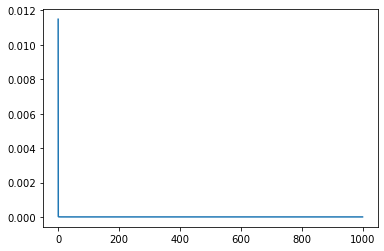

In [36]:
plt.plot(time[0:1000000],cost[0:1000000])

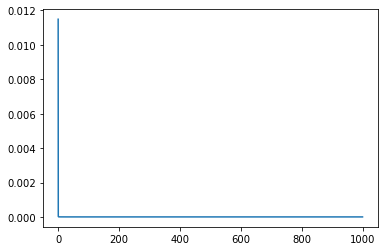

In [37]:
plt.plot(time[0:1000000],Opt_cost[0:1000000])

In [38]:
Opt_cost[0]

0.011484152484125544

In [39]:
cost[0]

0.011484356401295715

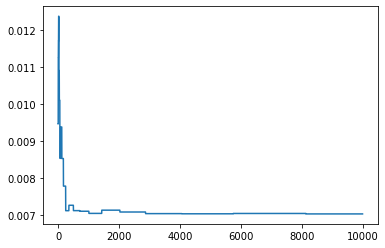

In [40]:
#Testing convergence of parameter estimation:
#print(LA.norm((Augmented-AtBt),'fro'))
err=np.zeros((time.shape[0]))
for t in range(time.shape[0]):
    AtBt=np.column_stack((A_dynamics[t],B_dynamics[t]))
    err[t]=LA.norm((Augmented-AtBt),'fro')
    
plt.plot(time[0:time.shape[0]],err[0:time.shape[0]])

In [41]:
print(err[0:10]) #if same then parameter estimation never takes place

[0.00946944 0.00946944 0.00946944 0.00946944 0.00946944 0.00946944
 0.00946944 0.00946944 0.00946944 0.00946944]


In [42]:
print(err[0])

0.00946944472831679


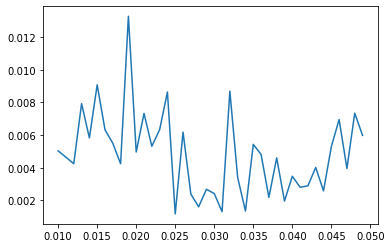

In [43]:
plt.plot(time[10:50],z_norm[10:50])

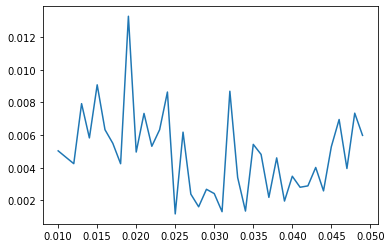

In [44]:
plt.plot(time[10:50],x_norm[10:50])

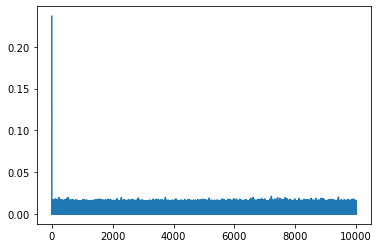

In [45]:
plt.plot(time[0:time.shape[0]],Opt_x_norm[0:time.shape[0]])

In [46]:
Opt_Final_Cost

86.19390508280395

In [47]:
ct       #last iterate instantaneous cost of OSLO

2.753948454131455e-06

In [48]:
nct     #last iterate instantaneous cost of the optimal policy

1.051385374221678e-05

In [49]:
Final_Cost

86.08012844034913

In [50]:
V_det=np.zeros((time.shape[0]+1))

In [51]:
for t in range(time.shape[0]+1):
    V_det[t]=np.linalg.det(V_dynamics[t])


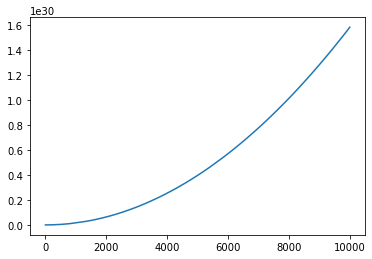

In [52]:
plt.plot(time,V_det[0:time.shape[0]])

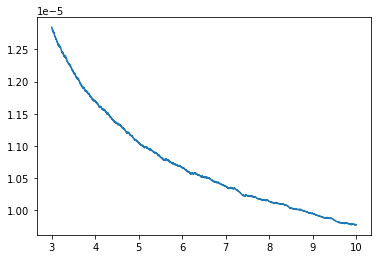

In [53]:
plt.plot(time[3000:10000],cost[3000:10000])

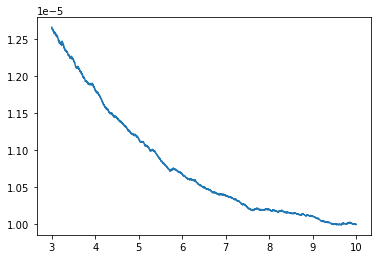

In [54]:
plt.plot(time[3000:10000],Opt_cost[3000:10000])

In [55]:
avg_regret=np.zeros((time.shape[0]))
for t in range((time.shape[0])):
    avg_regret[t]=cost[t]-Opt_cost[t]
    #avg_regret[t]*=(t+1)
    

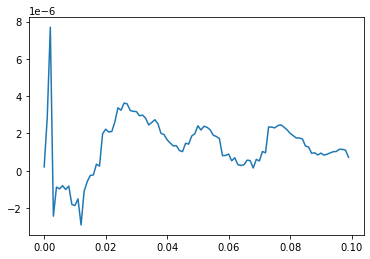

In [56]:
plt.plot(time[0:100],avg_regret[0:100])

In [57]:
dill.dump_session('notebook_env.db')

In [58]:
#dill.load_session('notebook_env.db')     #Uncomment this left command to load

In [59]:
K[1000000]

array([[-0.0007807 , -0.00271589],
       [ 0.00498821,  0.01625598]])

In [60]:
K_dynamics[1000000]

array([[ 0.00073431,  0.00265598],
       [-0.00507758, -0.01676571]])

In [61]:
agg_regret=np.zeros((time.shape[0]))
for t in range((time.shape[0])):
    agg_regret[t]=agg_cost_dynamics[t]-agg_Opt_cost[t]
    

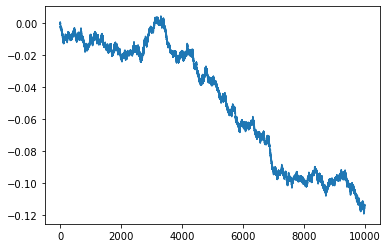

In [62]:
plt.plot(time[0:10000000-1],agg_regret[0:10000000-1])

In [63]:
for t in range((time.shape[0])):
    avg_regret[t]=agg_regret[t]/(t+1)

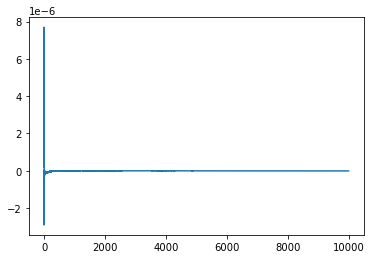

In [64]:
plt.plot(time[0:10000000-1],avg_regret[0:10000000-1])

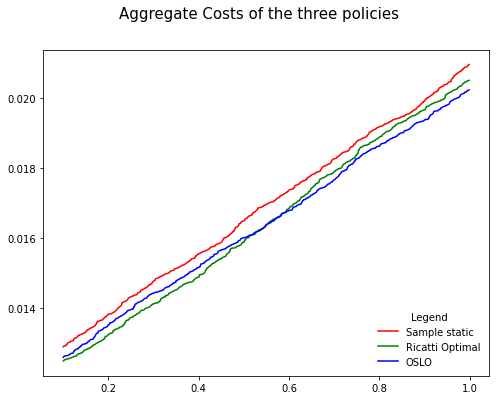

In [99]:

# Initialise the figure and axes.
fig, ax = plt.subplots(1, figsize=(8, 6))


# Set the title for the figure
fig.suptitle('Aggregate Costs of the three policies', fontsize=15)

# Draw all the lines in the same plot, assigning a label for each one to be
# shown in the legend.
ax.plot(time[100:1000], agg_cost[100:1000], color="red", label="Sample static")
ax.plot(time[100:1000], agg_Opt_cost[100:1000], color="green", label="Ricatti Optimal")
ax.plot(time[100:1000], agg_cost_dynamics[100:1000], color="blue", label="OSLO")
#ax.plot(time, agg_regret, color="red", label="Sum Regret")
#ax.plot(time, avg_regret,color="black", label="Average Regret")
# Add a legend, and position it on the lower right (with no box)
plt.legend(loc="lower right", title="Legend", frameon=False)

plt.show()


In [66]:
#V=V_dynamics[time.shape[0]-1]
V=V_dynamics[5000000]
V_inv=np.linalg.inv(V)
Sigma_relaxed=SDP_solver(A,B,V)

Left=np.array([[1,0,0,0],[0,1,0,0]])
Right=np.array([[1,0],[0,1],[0,0],[0,0]])


Sigma_relaxed_xx=(Left.dot(Sigma_relaxed)).dot(Right)
Sigma_relaxed_xx_inv=np.linalg.inv(Sigma_relaxed_xx)
K_final=(Sigma_relaxed[2:4,0:2]).dot((Sigma_relaxed_xx_inv))

print(K_final)
print(-K[1000])

WARN: m less than n, problem likely degenerate
[[ 0.00078034  0.00271521]
 [-0.00498674 -0.01625303]]
[[ 0.0007807   0.00271589]
 [-0.00498821 -0.01625598]]


In [67]:
mu*big_dot(Sigma_relaxed,V_inv)*bigI

array([[1.07282542e-10, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 1.07282542e-10, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 1.07282542e-10, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.07282542e-10]])

In [68]:
Sigma_relaxed_xx

array([[1.25617849e-05, 6.91937046e-08],
       [6.91937046e-08, 1.25929340e-05]])

In [69]:
agg_cost_dynamics[100]

0.012598651952685232

In [70]:
agg_Opt_cost[100]

0.012494334991350766

In [71]:
agg_cost_dynamics[1000]

0.020245557927484364

In [72]:
agg_Opt_cost[1000]

0.02052058672281907

In [73]:
agg_cost_dynamics[10000]

0.09771695697598191

In [74]:
agg_Opt_cost[10000]

0.09996516758869115

In [75]:
agg_cost_dynamics[100000]

0.8672763561751912

In [76]:
agg_Opt_cost[100000]

0.8778947649066764

In [77]:
agg_cost_dynamics[1000000]

8.636388660540357

In [78]:
agg_Opt_cost[1000000]

8.644565860969156

In [79]:
agg_cost_dynamics[10000000-1]

86.08013429452815

In [80]:
agg_Opt_cost[10000000-1]

86.19389457121132

In [81]:
#noise_variance*(Tr(Q+K.T*R*K))

#Guessing instantaneous cost of OSLO


var1*np.trace(Q+np.dot(K_final.T,np.dot(R,K_final)))

array([8.53986759e-06])

In [82]:
#noise_variance*(Tr(Q+K.T*R*K))

#Guessing instantaneous cost of OSLO


var1*np.trace(Q+np.dot(K[1000].T,np.dot(R,K[1000])))

array([8.53986814e-06])

In [83]:
ct

2.753948454131455e-06

In [84]:
nct

1.051385374221678e-05

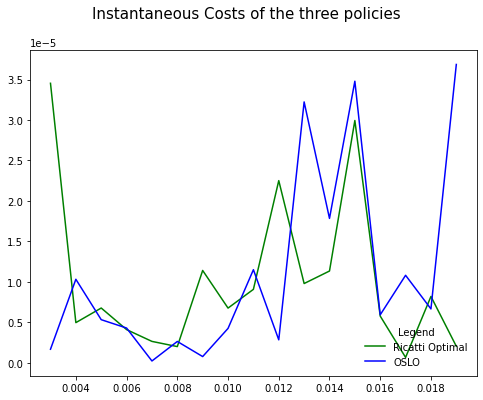

In [85]:
# Initialise the figure and axes.
fig, ax = plt.subplots(1, figsize=(8, 6))


# Set the title for the figure
fig.suptitle('Instantaneous Costs of the three policies', fontsize=15)

# Draw all the lines in the same plot, assigning a label for each one to be
# shown in the legend.
#ax.plot(time[1000:10000000], ins[1000:10000000], color="red", label="Sample static")
ax.plot(time[3:20], ins_Opt[3:20], color="green", label="Ricatti Optimal")
ax.plot(time[3:20], ins_dynamics[3:20], color="blue", label="OSLO")
#ax.plot(time, agg_regret, color="red", label="Sum Regret")
#ax.plot(time, avg_regret,color="black", label="Average Regret")
# Add a legend, and position it on the lower right (with no box)
plt.legend(loc="lower right", title="Legend", frameon=False)

plt.show()

In [86]:
-K[3]

array([[ 0.0007807 ,  0.00271589],
       [-0.00498821, -0.01625598]])

In [87]:
K_dynamics[3]

array([[ 0.00085694,  0.00276524],
       [-0.00575313, -0.01746155]])

In [88]:
-K[5]

array([[ 0.0007807 ,  0.00271589],
       [-0.00498821, -0.01625598]])

In [89]:
-K[0]

array([[ 0.0007807 ,  0.00271589],
       [-0.00498821, -0.01625598]])

In [90]:
K_dynamics[0]

array([[ 0.00085694,  0.00276524],
       [-0.00575313, -0.01746155]])

In [91]:
P[1000]

array([[0.20041448, 0.13299527],
       [0.13299527, 0.48848435]])

In [92]:
P[10000000-1]

array([[0.19986978, 0.13135191],
       [0.13135191, 0.4830391 ]])

In [93]:
P[1000000]

array([[0.20041448, 0.13299527],
       [0.13299527, 0.48848435]])

In [94]:
var1*np.trace(P[0])

array([8.61331265e-06])

In [95]:
np.dot(A.T,np.dot(P[0],A))+Q-np.dot(A.T,np.dot(P[0],np.dot(B,np.dot(np.linalg.inv(R+np.dot(B.T,np.dot(P[0],B))),np.dot(B.T,np.dot(P[0],A)))))) 

array([[0.20041448, 0.13299527],
       [0.13299527, 0.48848435]])

In [96]:
P[0]

array([[0.20041448, 0.13299527],
       [0.13299527, 0.48848435]])

In [97]:
new_regret=np.zeros((time.shape[0]))
for t in range((time.shape[0])):
    new_regret[t]=cost[t]-var1*np.trace(P[0])
    #avg_regret[t]*=(t+1)

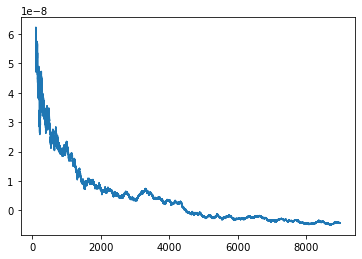

In [101]:
plt.plot(time[100000:9000000],new_regret[100000:9000000])